In [1]:
import sys, os
import shutil
import pandas as pd
import tensorflow as tf
from tensorflow.python.ops import array_ops
import numpy as np
%matplotlib inline
import random
import matplotlib.pyplot as plt
import pathlib
import platform



In [2]:
tf.__version__

'2.0.0-dev20191002'

## Load data

In [3]:
data_name = 'smote_borderline'
TRAIN_PATH = "../data/{}/".format(data_name)
TEST_PATH = "../data/test"
ALL_DATA = "../data/all"

IMAGE_SIZE = 227,227
label_names = {0:'Negative', 1:'Positive'}
SYS_SEP = '\\' if platform.system()=='Windows' else '/'

In [4]:
def process_path(file_path):
    parts = tf.strings.split(file_path, SYS_SEP)

    return file_path, int(parts[-2] == b'Positive')

def load_dataset(data_root="../data/", train_data=False, path_negative_data="../data/train/Negative" ):
    data_root = pathlib.Path(data_root)
    list_dirs = [str(data_root/'*/*.jpg'),str(data_root/'*/*.png')]
    if train_data:
                
        path_negative_data = pathlib.Path(path_negative_data)
        list_dirs.append(str(path_negative_data/'*.jpg'))

    list_ds = tf.data.Dataset.list_files(list_dirs)
    
    SIZE = len(list(list_ds))
    labeled_ds = list_ds.map(process_path)
      
    return labeled_ds, SIZE


In [5]:
labeled_train_ds,TRAIN_SIZE = load_dataset(TRAIN_PATH, train_data=True)
labeled_test_ds,TEST_SIZE = load_dataset(TEST_PATH)


In [6]:
for image_raw, label_text in labeled_train_ds.take(3):
    print(label_text.numpy())
    print(repr(image_raw.numpy()[-100:]))
    print()


1
b'../data/smote_borderline/Positive/8164_smote_borderline.jpg'

0
b'../data/train/Negative/08064.jpg'

1
b'../data/smote_borderline/Positive/2178_smote_borderline.jpg'



In [7]:
TRAIN_SIZE,TEST_SIZE

(20252, 12000)

### Display some examples

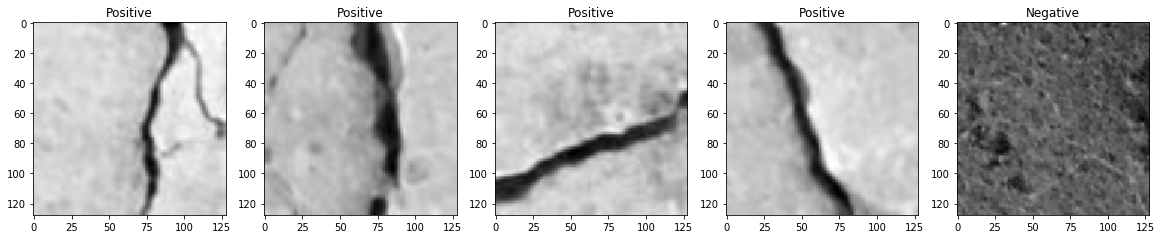

In [8]:
## import IPython.display as display
fig = plt.figure(figsize=(20, 20))
ix=0
nb_images = 5
for img,label in labeled_train_ds.take(nb_images):
    img = tf.io.read_file(img)
    img=tf.image.decode_image(img, channels=1)

    img = tf.image.resize_with_pad(img,target_height=128,target_width=128,antialias=True,method='gaussian')
    
    ix+=1
    a=fig.add_subplot(1,nb_images,ix)
    imgplot = plt.imshow(img[:,:,0],cmap='gray')
    a.set_title(str(label_names[label.numpy()]))
    

In [9]:
np_image = img.numpy()

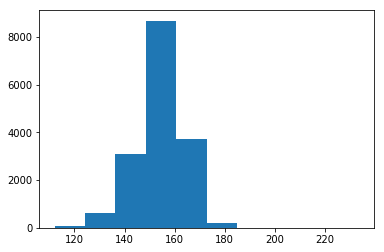

In [10]:
plt.hist(np_image.ravel())
plt.show()

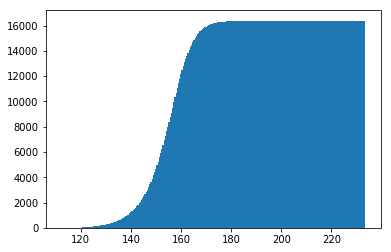

In [11]:
plt.hist(np_image.ravel(), bins=255, cumulative=True)
plt.show()

## Preprocessing Data

### contrast stretching

In [12]:
def contrast_stretching(np_image,low_percentile=1, up_percentile=99):
    pl = np.percentile(np_image, low_percentile)
    pu = np.percentile(np_image, up_percentile)
    image_ct = exposure.rescale_intensity(np_image, in_range=(pl, pu))
    return image_ct



### extracting edges

Negative
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


/usr/local/lib/python3.7/site-packages/skimage/exposure/exposure.py:124: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


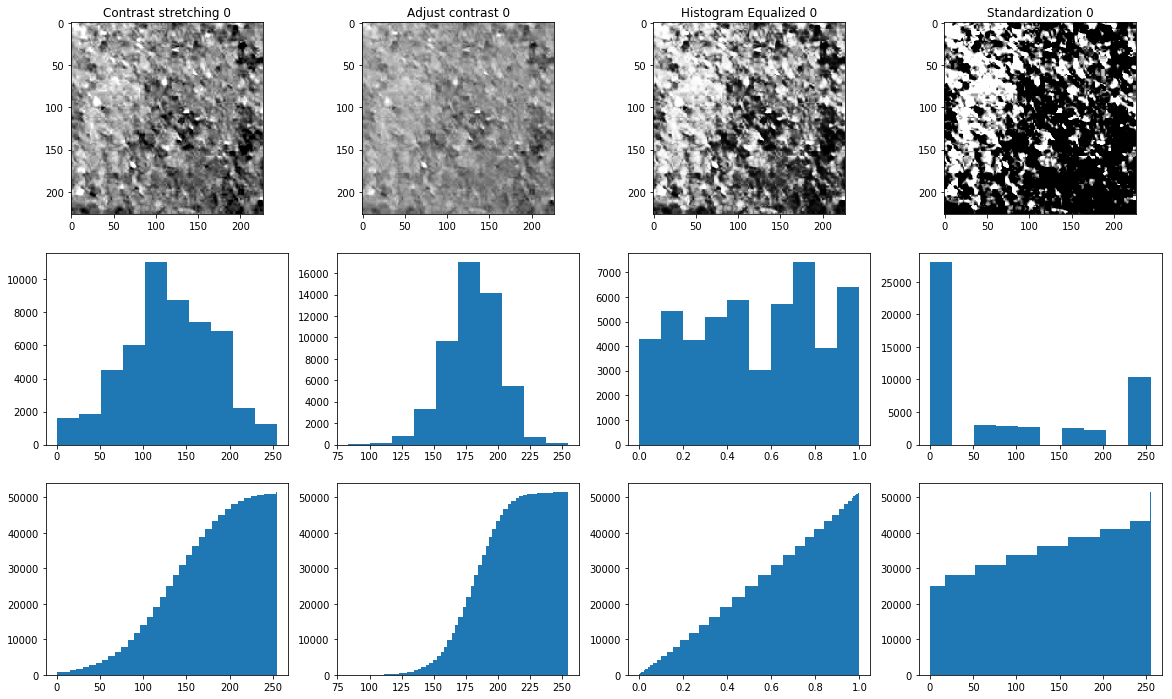

Positive


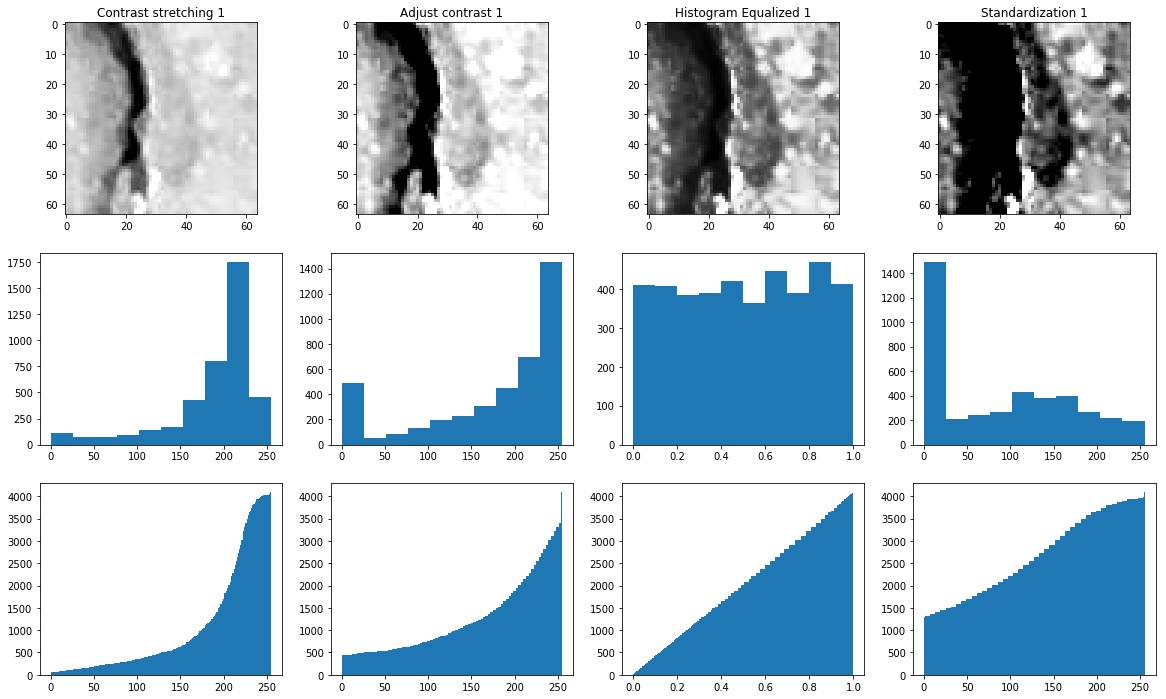

In [13]:
from skimage import exposure
import numpy as np

# Read image
image_paths = []
image_paths.append(random.choice([(x,y) for (x,y) in list(labeled_train_ds.take(100)) if  y==0]))
image_paths.append(random.choice([(x,y) for (x,y) in list(labeled_train_ds.take(100)) if  y==1]))

for image,classe in image_paths :
    classe = classe.numpy()
    print(label_names[classe])
    image = tf.io.read_file(image)
    image=tf.image.decode_image(image, channels=1)
    np_image = image.numpy()
    # Contrast stretching
    image_cs = contrast_stretching(np_image)
    
    # Adjust contrast 
    image_ac = tf.image.adjust_contrast(np_image, contrast_factor=2.91).numpy()

    # Histogram Equalization
    image_eq = exposure.equalize_hist(np_image)

    # per image standardization
    image_std = tf.image.per_image_standardization(np_image).numpy()


    # Show the images
    fig = plt.figure(figsize=(20, 12))

    # Subplot for original image
    a=fig.add_subplot(3,4,1)
    imgplot = plt.imshow(image_cs[:,:,0],cmap='gray')
    a.set_title('Contrast stretching '+str(classe))

    # Subplot for contrast stretched image
    a=fig.add_subplot(3,4,2)
    imgplot = plt.imshow(image_ac[:,:,0],cmap='gray')
    a.set_title('Adjust contrast '+str(classe))

    # Subplot for equalized image
    a=fig.add_subplot(3,4,3)
    imgplot = plt.imshow(image_eq[:,:,0],cmap='gray')
    a.set_title('Histogram Equalized '+str(classe))

    # Subplot for equalized image
    a=fig.add_subplot(3,4,4)
    imgplot = plt.imshow(image_std[:,:,0],cmap='gray')
    a.set_title('Standardization '+str(classe))


    # Subplots for histograms
    a=fig.add_subplot(3,4,5)
    imgplot = plt.hist(image_cs.ravel())

    a=fig.add_subplot(3,4,6)
    imgplot = plt.hist(image_ac.ravel())

    a=fig.add_subplot(3,4,7)
    imgplot = plt.hist(image_eq.ravel())

    a=fig.add_subplot(3,4,8)
    imgplot = plt.hist(image_std.ravel())


    # Subplots for CDFs

    a=fig.add_subplot(3,4,9)
    imgplot = plt.hist(image_cs.ravel(), bins=255, cumulative=True)

    a=fig.add_subplot(3,4,10)
    imgplot = plt.hist(image_ac.ravel(), bins=255, cumulative=True)

    a=fig.add_subplot(3,4,11)
    imgplot = plt.hist(image_eq.ravel(), bins=255, cumulative=True)

    a=fig.add_subplot(3,4,12)
    imgplot = plt.hist(image_std.ravel(), bins=255, cumulative=True)

    plt.show()

In [14]:
def sobel_grad_euclidian_component(image):
    grad_mag_square = tf.sqrt(tf.math.reduce_sum(tf.math.pow(image,2),axis=-1)) #  compute magnitude components norm2
    scale_factor = tf.math.reduce_max(grad_mag_square)/255.0
    grad_mag_square = tf.math.divide(grad_mag_square,scale_factor)
    return  grad_mag_square


 
def sobel_grad_manhattan_component(image):
    grad_mag_components = tf.math.abs(image)
    grad_mag_components = tf.math.reduce_sum(grad_mag_components,axis=-1) # sum all magnitude components
    scale_factor = tf.math.divide(tf.math.reduce_max(grad_mag_components),255.0)

    return tf.math.divide(grad_mag_components, scale_factor)
    
    

In [15]:
image,label=random.choice([x for x in list(labeled_train_ds.take(5)) ])
image = tf.io.read_file(image)
image = tf.image.decode_image(image, channels=1)

array_ops.expand_dims(image, 0).shape

TensorShape([1, 64, 64, 1])

image_sobel_grad shape :  (64, 64, 1)
image_sobel_grad shape :  (1, 64, 64, 1)
image_sobel_grad :  (0.0, 255.0)
image_sobel_grad_manhattan :  (0.0, 255.0)
image :  (0.0, 1.0)
(64, 64, 1)


Text(0.5, 1.0, 'manhattan')

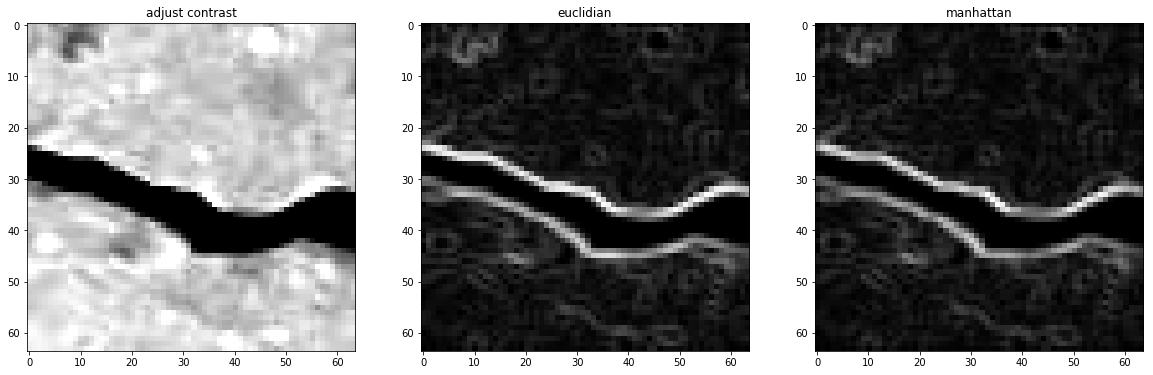

In [16]:

image,label=random.choice([x for x in list(labeled_train_ds.take(5)) if x[1] == 1])
image = tf.io.read_file(image)
image = tf.image.decode_image(image, channels=1)

# Contrast stretching
image = tf.image.adjust_contrast(image, contrast_factor=2.91)


image = tf.dtypes.cast(image, tf.float32)

## reshape input image

print("image_sobel_grad shape : ", image.shape)
image_reshape = tf.reshape(image, [1]+ image.shape)
## Extract edges (Sobel algorithme)
image_edges = tf.image.sobel_edges(image_reshape)
image_sobel_grad_manhattan = sobel_grad_manhattan_component(image_edges)
image_sobel_grad = sobel_grad_euclidian_component(image_edges)
print("image_sobel_grad shape : ", image_sobel_grad.shape)
#image_edges_reshape = tf.reshape(image_edges[:,:,:,:],[IMAGE_SIZE[0], IMAGE_SIZE[1],6])
print("image_sobel_grad : ", (tf.math.reduce_min(image_sobel_grad).numpy(), tf.math.reduce_max(image_sobel_grad).numpy()) )
print("image_sobel_grad_manhattan : ", (tf.math.reduce_min(image_sobel_grad_manhattan).numpy(), tf.math.reduce_max(image_sobel_grad_manhattan).numpy()))

image = tf.divide(image,255.0)  # normalize to [0,1] range
#image = tf.image.per_image_standardization(image)
print("image : ", (tf.math.reduce_min(image).numpy(), tf.math.reduce_max(image).numpy()))
print(image.shape)
fig = plt.figure(figsize=(20, 12))
a=fig.add_subplot(1,3,1)
plt.imshow(image[:,:,0],cmap='gray')
plt.title("adjust contrast")

a=fig.add_subplot(1,3,2)
plt.imshow(image_sobel_grad[0,:,:,0],cmap='gray')
plt.title("euclidian")

a=fig.add_subplot(1,3,3)
plt.imshow(image_sobel_grad_manhattan[0,:,:,0],cmap='gray')
plt.title("manhattan")



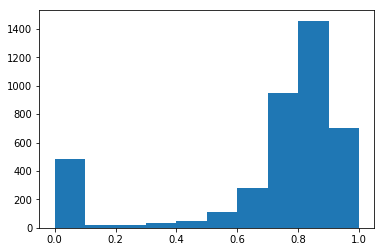

In [17]:
plt.hist(image.numpy().ravel())
plt.show()

### Converting to black and white

 Wrap these up in simple functions for later.

In [18]:
IMAGE_SIZE = 64
NUM_CAT = 2
def preprocess_image(image,label):
    image = tf.image.decode_image(image, channels=1,dtype=tf.float32)

    # Resizing with pad 
    image_resize = tf.image.resize_with_pad(image,target_height=IMAGE_SIZE,
                                     target_width=IMAGE_SIZE,
                                     antialias=True,method='gaussian')
    
    
    # Adjusting Contrast
    image_adjust_contrast = tf.image.adjust_contrast(image_resize, contrast_factor=2.91)
    image_adjust_contrast = array_ops.expand_dims(image_adjust_contrast, 0)
    
    # Apply sobel algorithm
    image_sobel_edges = tf.image.sobel_edges(image_adjust_contrast)

    # compute gradient dx^2 + dy^2
    image = sobel_grad_euclidian_component(image_sobel_edges)    
        
    
    image = tf.math.divide(image,255.0)  # normalize to [0,1] range
    # reshape image
    image = array_ops.reshape(image, (IMAGE_SIZE,IMAGE_SIZE,1))
    
    # One Hot encoding of the label
    label_one_hot = tf.one_hot(label, depth=NUM_CAT)
 
    return image,label_one_hot



In [19]:
def _load_and_preprocess_image(image,label):
    image = tf.io.read_file(image)
    return preprocess_image(image,label)


image_adjust_contrast.shape :  (1, 64, 64, 1)
image_adjust_contrast.shape :  (1, 64, 64, 1)


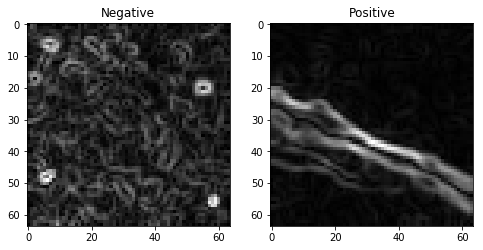

In [20]:
images = []
images.append(random.choice([(x,y) for (x,y) in list(labeled_train_ds.take(10)) if  y==0]))
images.append(random.choice([(x,y) for (x,y) in list(labeled_train_ds.take(10)) if  y==1]))
ix = 0
fig = plt.figure(figsize=(8, 12))

for image,label in images :
    ix+=1
    image,label_tf = _load_and_preprocess_image(image,label)
    a=fig.add_subplot(1,2,ix)
    plt.imshow(image[:,:,0]*255, cmap="gray")
    plt.title(label_names[label.numpy()])



In [21]:
# random transformation that we can use to oversample the dataset (has not been used )

def _image_augmentation(image, label):
    # Flip image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    # Random Brightness
    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    # Random Saturation RGB image on 3 channels
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5,)
    # Clip values between 0 and 1
    image = tf.clip_by_value(image, 0.0, 1.0)
    # Rotation 
    image = tf.keras.preprocessing.image.random_rotation(image,0.1)


    return image, label


## Build a dataset of images

In [22]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n][:,:,0], cmap='gray')
        plt.title(label_names[tf.math.argmax(label_batch[n]).numpy()].title())
        plt.axis('off')


In [23]:
def prepare_for_training(ds, shuffle_buffer_size=1000, BATCH_SIZE=64, prefetch_buffer_size=1):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model is training.
    ds = ds.prefetch(buffer_size=1)

    return ds


In [24]:
TRAIN_BATCH_SIZE = 256


In [52]:
for a,b in labeled_train_ds.take(1):
    print (a,b)

tf.Tensor(b'../data/smote_borderline/Positive/1429_smote_borderline.jpg', shape=(), dtype=string) tf.Tensor(1, shape=(), dtype=int32)


In [25]:
# Map for input preprocessing
ds_train = labeled_train_ds.map(_load_and_preprocess_image)

# Map for image augmentation (uncomment if you want to use the data augmentation by random transformations)
#ds_train = ds_train.map(_image_augmentation) 

# Shuffle, Repeat, Batch, and Prefetch dataset
ds_train = prepare_for_training(ds_train, shuffle_buffer_size=TRAIN_SIZE, BATCH_SIZE=TRAIN_BATCH_SIZE)


image_adjust_contrast.shape :  (1, 64, 64, None)


In [26]:
ds_train

<PrefetchDataset shapes: ((None, 64, 64, 1), (None, 2)), types: (tf.float32, tf.float32)>

In [27]:
# Get the first batch 
image_batch, label_batch = next(iter(ds_train))

In [28]:
ds_train

<PrefetchDataset shapes: ((None, 64, 64, 1), (None, 2)), types: (tf.float32, tf.float32)>

In [29]:
print("Image shape: ", image_batch.shape)
print("Label: ", (label_batch.shape, label_batch[0].numpy()))

Image shape:  (256, 64, 64, 1)
Label:  (TensorShape([256, 2]), array([1., 0.], dtype=float32))


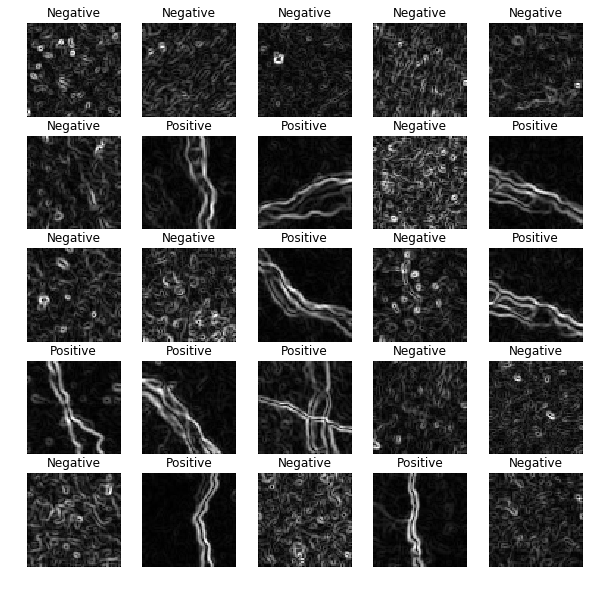

In [30]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [31]:
TEST_BATCH_SIZE = 128

In [32]:
# Map for input preprocessing
ds_test = labeled_test_ds.map(_load_and_preprocess_image)

# Shuffle, Repeat, Batch, and Prefetch dataset
ds_test = prepare_for_training(ds_test, shuffle_buffer_size=TEST_SIZE, BATCH_SIZE=TEST_BATCH_SIZE)


image_adjust_contrast.shape :  (1, 64, 64, None)


In [33]:
# Get the first batch 
image_batch, label_batch = next(iter(ds_test))

In [34]:
print("Image shape: ", image_batch.shape)
print("Label: ", (label_batch.shape, label_batch[0].numpy()))


Image shape:  (128, 64, 64, 1)
Label:  (TensorShape([128, 2]), array([1., 0.], dtype=float32))


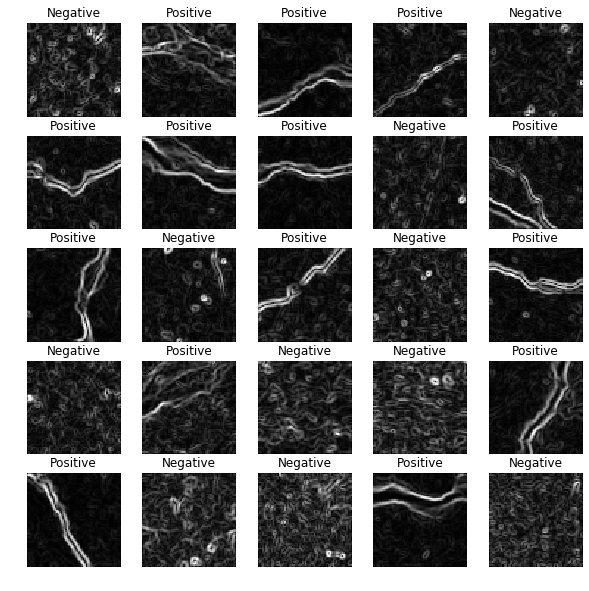

In [35]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Build the model



In [36]:
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

### Models Params 

In [37]:
TRAIN_BATCH_SIZE

256

In [38]:

INPUT_SHAPE = (IMAGE_SIZE,IMAGE_SIZE,1)
NUM_EPOCHS = 20
TRAIN_STEPS_PER_EPOCH = TRAIN_SIZE//TRAIN_BATCH_SIZE
TEST_STEPS_PER_EPOCH = TEST_SIZE//TEST_BATCH_SIZE


In [39]:
tf.keras.backend.clear_session()

def create_model():
    model = Sequential()

    model.add(Conv2D(16, (5, 5), activation="relu", input_shape=INPUT_SHAPE))

    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(16, (5, 5), activation="relu", input_shape=INPUT_SHAPE))

    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (5, 5), activation="relu", kernel_initializer = 'he_uniform', 
                     activity_regularizer=l1_l2(l1=0.2, l2=0.4)) )
    model.add(BatchNormalization())

    model.add(MaxPooling2D((4, 4)))

    model.add(Flatten(name='flattened'))
    model.add(Dropout(0.5))
    model.add(Dense(units=512, activation="relu"))
    model.add(Dropout(0.3))
    # binary output
    model.add(Dense(units=2, activation='softmax', name='output'))
    return model
model = create_model()
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 16)        6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 32)          12832     
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 32)          128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0

In [40]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=binary_crossentropy, metrics=['AUC'])#[tf.keras.metrics.AUC()])


In [41]:
import datetime
now_str = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")

saved_model_path = "../log/model/{}/".format(now_str)
LOG_DIR = '../tensorboard-log/tf_{}_data/{}/'.format(data_name, now_str)

min_delta=.0005
patience=5
use_early_stop=True


if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)
    
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)    


# checkpoint to save model after each epoch
save_best = ModelCheckpoint(saved_model_path+"weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5",
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True)

# stop training if the validation error stops improving.
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=min_delta,
                           patience=patience,
                           verbose=1)


tensorboard = TensorBoard(log_dir=LOG_DIR, histogram_freq=1,write_images=True,embeddings_freq=1)



callbacks_list = [tensorboard,save_best]

if use_early_stop:
    callbacks_list.append(early_stop)
    



In [42]:
mirrored_strategy = tf.distribute.MirroredStrategy()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [43]:
hist = model.fit(x=ds_train,
                steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                epochs=NUM_EPOCHS,
                verbose=1,
                validation_data=ds_test,
                validation_steps=TEST_STEPS_PER_EPOCH, 
                callbacks=callbacks_list,)

Train for 79 steps, validate for 93 steps
Epoch 1/20
78/79 [============================>.] - ETA: 0s - loss: 0.6608 - AUC: 0.9594
Epoch 00001: val_loss improved from inf to 1.27487, saving model to ../log/model/2019_11_20_14_17/weights-improvement-01-1.27.hdf5
79/79 [==============================] - 105s 1s/step - loss: 0.6551 - AUC: 0.9599 - val_loss: 1.2749 - val_AUC: 0.7101
Epoch 2/20
78/79 [============================>.] - ETA: 0s - loss: 0.1573 - AUC: 0.9918
Epoch 00002: val_loss improved from 1.27487 to 1.16838, saving model to ../log/model/2019_11_20_14_17/weights-improvement-02-1.17.hdf5
79/79 [==============================] - 70s 880ms/step - loss: 0.1575 - AUC: 0.9918 - val_loss: 1.1684 - val_AUC: 0.7325
Epoch 3/20
78/79 [============================>.] - ETA: 0s - loss: 0.1197 - AUC: 0.9950
Epoch 00003: val_loss did not improve from 1.16838
79/79 [==============================] - 68s 863ms/step - loss: 0.1191 - AUC: 0.9950 - val_loss: 1.1974 - val_AUC: 0.7269
Epoch 4/20

In [44]:
now_str = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")

saved_model_path = "../models/{}".format(now_str)
if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)
'{}/{}.h5'.format(saved_model_path,"model")

'../models/2019_11_20_14_44/model.h5'

2018 – Özgenel, Ç.F., Gönenç Sorguç, A. “Performance Comparison of Pretrained Convolutional Neural Networks on Crack Detection in Buildings”, ISARC 2018, Berlin.

Lei Zhang , Fan Yang , Yimin Daniel Zhang, and Y. J. Z., Zhang, L., Yang, F., Zhang, Y. D., & Zhu, Y. J. (2016). Road Crack Detection Using Deep Convolutional Neural Network. In 2016 IEEE International Conference on Image Processing (ICIP). http://doi.org/10.1109/ICIP.2016.7533052